In [5]:
%%capture
import pandas as pd
# import modin.pandas as pd
import numpy as np

import math
import seaborn as sns
import matplotlib.pyplot as plt
# import vaex # https://vaex.io/docs/index.html
import pathlib
from pathlib import *
import os
import pickle
# import cufflinks as cf
# import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

init_notebook_mode(connected=True)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from shapely.geometry import Point, Polygon

In [6]:
##TODO -> Create functions for repetitive tasks

# ,skiprows=range(3, 260000000)
# Input the csv
# Extracting a subset of 1000000 rows by default
def load_data(dir_name,base_filename):
    complete_path=os.path.join(dir_name, base_filename + "." + "csv")
    # df=pd.read_csv(complete_path,sep=';',encoding= 'unicode_escape',nrows=10000,engine='c',infer_datetime_format=True,usecols=['Trip_Summary_Id','Numberplate','Point_time-stamp','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Road_form','Speed_restriction','TNO_Time-stamp'])
    # df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=5000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False,usecols=['Numberplate','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Speed_restriction','TNO_Time-stamp'])))
    
    df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=20000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False)))
    return df

# Dropping the first and last row of csv ("------")
def drop_first_row(df):
    df=df.iloc[1:]
    df=df[:-1]
    return df

def resetIndex(df):
    return df.reset_index()


##TODO -> Rewrite this function

def cast_to_correct_dtype(df):
    
    if 'Id' in df.columns:
        df['Id'] = df['Id'].astype('int')
        
    if 'AOS_position_Id' in df.columns:
        df['AOS_position_Id'] = df['AOS_position_Id'].astype('int')
    
    if 'Acceleration_x' in df.columns:
        df['Acceleration_x'] = df['Acceleration_x'].astype('float')
        
    if 'Acceleration_y' in df.columns:
        df['Acceleration_y'] = df['Acceleration_y'].astype('float')
        
    if 'TNO_Valid' in df.columns:
        df['TNO_Valid'] = df['TNO_Valid'].astype('int')
    
    if 'Latitude' in df.columns:
        df['Latitude'] = df['Latitude'].astype('float')
        
    if 'Longitude' in df.columns:
        df['Longitude'] = df['Longitude'].astype('float')
        
    if 'Event/action_speed' in df.columns:
        df['Event/action_speed'] = df['Event/action_speed'].astype('int')
        
    if 'Event/action_type' in df.columns:
        df['Event/action_type'] = df['Event/action_type'].astype('int')    
        
    if 'Number_of_lanes' in df.columns:
        df['Number_of_lanes'] = df['Number_of_lanes'].astype('int')
        
    if 'Road_class' in df.columns:
        df['Road_class'] = df['Road_class'].astype('int')
        
    if 'Road_type' in df.columns:
        df['Road_type'] = df['Road_type'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id']=df['Crash_position_Id'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id'] = df['Crash_position_Id'].astype('int')
        
    if 'Point_speed' in df.columns:
        df['Point_speed'] = df['Point_speed'].astype('float')
        
    if 'Average_speed_fpp' in df.columns:
        df['Average_speed_fpp'] = df['Average_speed_fpp'].astype('float')  
        
    if 'Average_Speed' in df.columns:
        df['Average_Speed'] = df['Average_Speed'].astype('float')        

    if 'Maximum_speed' in df.columns:
        df['Maximum_speed'] = df['Maximum_speed'].astype('float')     
        
    if 'Meters_travelled' in df.columns:
        df['Meters_travelled'] = df['Meters_travelled'].astype('int')  

    if 'Road_form' in df.columns:
        df['Road_form'] = df['Road_form'].astype('int') 
        
    if 'Speed_restriction' in df.columns:
        df['Speed_restriction'] = df['Speed_restriction'].astype('int') 
        
    if 'Crash_speed' in df.columns:
        df['Crash_speed'] = df['Crash_speed'].astype('int')
        
    if 'Maximum_acceleration' in df.columns:
        df['Maximum_acceleration'] = df['Maximum_acceleration'].astype('float')
        
    if 'Numberplate' in df.columns:
        df['Numberplate']=df['Numberplate'].astype('str')
        

    return df

            

## Handling date time related fields

def cast_date_time(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS_event/action_time']=pd.datetime(df['AOS_event/action_time'],errors='coerce')
        df['AOS_event/action_time_hour']=df['AOS_event/action_time'].dt.hour
    
    if 'TNO_Trip-start' in df.columns:
        df['TNO_Trip-start'] = pd.to_datetime(df['TNO_Trip-start'],errors='coerce')
        df['TNO_Trip-start_hour'] = df['TNO_Trip-start'].dt.hour
        
    if 'TNO_Trip-end' in df.columns:
        df['TNO_Trip-end'] = pd.to_datetime(df['TNO_Trip-end'],errors='coerce')
        
    if 'Position_time' in df.columns:
        df['Position_time'] = pd.to_datetime(df['Position_time'],errors='coerce')

    if 'TNO_Time-stamp' in df.columns:
        df['TNO_Time-stamp'] = pd.to_datetime(df['TNO_Time-stamp'],errors='coerce')
        df['TNO_Time-stamp_hour'] = df['TNO_Time-stamp'].dt.hour
        
    return df

## Converting Time Stamps to datetime

def date_and_time_columns(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS Trip Date']=df['AOS_event/action_time'].dt.date
        df['AOS Event Time']=df['AOS_event/action_time'].dt.time
        df['AOS Trip Hour']=df['AOS_event/action_time'].dt.hour
    
    
    if 'TNO_Time-stamp' in df.columns:
        df['TNO Trip Date'] = df['TNO_Time-stamp'].dt.date
        df['TNO Trip Time'] = df['TNO_Time-stamp'].dt.time
        df['TNO Trip Hour']=df['TNO_Time-stamp'].dt.hour
        # df['TNO Trip Hour'] = df['TNO Trip Time'].dt.hour
    return df

def Time_of_the_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x < 12 ):
        return 'Morning'
    elif (x >= 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    
    
def rename_some_stuff(df):
    if 'Event/action_type' in df.columns:
        df["Event type Rename"]=df["Event/action_type"].replace({0: 'Headway Warning = OFF', 1: 'Headway Warning (long)', 2: 'Headway Warning (medium)'
                                                                                 ,3: 'Headway Warning (short)',10:'Lane Departure Warning = OFF',11:'Left Lane Departure Warning = ON'
                                                                                 ,12:'Right Lane Departure Warning = ON',13:'Left and Right Lane Departure Warning = ON'
                                                                                 ,20:' Indicators = OFF',21:'Left Indicator = ON',22:'Right Indicator = ON',23:'Left and Right Indicator = ON'
                                                                                 ,40:'Brakes = OFF',41:'Brakes = ON'})
        
    if 'Road_type' in df.columns:
        df["Road_type_Rename"]=df["Road_type"].replace({0: "Urban", 1: "Motorway",2:"Extra Urban",3:"Unavailable"})
        
    return df

def detect_overspeeding_count(df):
    # create a list of our conditions
    # if 'Event/action_speed' and 'Speed_restriction' in df.columns:
    #     conditions = [(df['Event/action_speed']> df['Speed_restriction'])]
    #     # # create a list of the values we want to assign for each condition
    #     values = [1]
    #     # create a new column and use np.select to assign values to it using our lists as arguments
    #     df['Overspeeding_event'] = np.select(conditions, values)
        
    # return df

    if 'Point_speed' and 'Speed_restriction' in df.columns:
        conditions = [(df['Point_speed']> df['Speed_restriction'])]
        # # create a list of the values we want to assign for each condition
        values = [1]
        # create a new column and use np.select to assign values to it using our lists as arguments
        df['Overspeeding_event'] = np.select(conditions, values)
        
    return df

def some_processing(df):
    if 'Meters_travelled' in df.columns:
        df['KmTravelled']=df['Meters_travelled']/1000
    return df

#### **Extract Files for different cities**

In [7]:
def select_city_to_explore(city_name):
    if city_name=='Amsterdam':
        city_coordinates = [(52.430779, 4.737382), (52.422361, 4.811680), (52.418126, 4.850948), 
                            (52.431506, 4.859627),(52.421959, 4.913905),(52.414543, 4.933522),(52.425437, 4.954927),
                            (52.428570, 4.982090),(52.423581, 5.017310),(52.417493, 5.067539),(52.397841, 5.031621),
                            (52.373215, 5.014760),(52.352051, 5.030236),(52.324595, 5.019149),(52.304151, 5.024817),
                            (52.277836, 4.960200),(52.307825, 4.925153),(52.318055, 4.910773),(52.323740, 4.820309),
                            (52.339239, 4.789761),(52.357192, 4.752847),(52.387835, 4.753389),(52.399444, 4.729131),(52.430091, 4.737165)]
    elif city_name=='Rotterdam':
        city_coordinates = [(51.964720, 4.379695), (51.979081, 4.427803), (51.982006, 4.467663), 
                            (51.963745, 4.515691),(51.975121, 4.546658),(51.986527, 4.558397),(51.995767, 4.594196),
                            (51.968611, 4.599813),(51.955476, 4.566894),(51.943379, 4.576685),(52.397841, 5.031621),
                            (51.905291, 4.577125),(51.868921, 4.570220),(51.868888, 4.396928),(51.964029, 4.377486)]
        
    elif city_name =="Zwolle":
        city_coordinates = [(52.549349, 6.004091), (52.568947, 6.063982), (52.554697, 6.089382), (52.568898, 6.101135),
                         (52.555875, 6.138225),(52.566288, 6.160296),(52.585973, 6.144575),(52.569103, 6.212615),
                         (52.537363, 6.193830),(52.517736, 6.181333),(52.495107, 6.202496),(52.480071, 6.194845),
                         (52.467620, 6.150828),(52.447958, 6.155530),(52.440524, 6.103350),(52.508357, 6.024621),
                         (52.526347, 6.010919),(52.531352, 6.026051),(52.550606, 5.999967)]
        
    return city_name,city_coordinates


#### **Select a city to explore**

In [8]:
city_name,city_coords=select_city_to_explore('Amsterdam')
# city_name,city_coords=select_city_to_explore('Rotterdam')
# city_name,city_coords=select_city_to_explore('Zwolle')

**Note - if files are already saved skip part I and load files directly (Part-II)**

## **Part I- Creating files**

#### Trip Detail

In [ ]:
import glob
import os


dir_name=r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\TripDetail"
base_filename=city_name

path=os.path.join(dir_name, base_filename)
# print(path)
all_files = glob.glob(os.path.join(path, "*.csv"))
df_inter_city_trip_detail = pd.concat((pd.read_csv(f,usecols=["Numberplate","Latitude","Longitude","Point_speed","Meters_travelled"]) for f in all_files), ignore_index=True)

#### Polygon Filtering

- Part I : Remove datapoints that have been recorded outside the NL

In [ ]:

def remove_data_points_outside_nl(df):
    # Create a polygon (around nl, some parts of belgium and germany)
    coords_nl_belgium_de = [(51.319810, 3.199518), (51.141676, 4.044834), (51.151092, 4.433142), (51.160870, 4.911878),
                            (51.119796, 5.379190),(50.916492, 5.347477),(50.732720, 5.558885),(50.646984, 5.868460),
                            (50.682498, 6.225990),(50.774220, 6.788565),(51.090741, 6.993645),(51.366330, 7.097475),
                            (51.706392, 7.281298),(52.086558, 7.481535),(52.401805, 7.644418),(52.863343, 7.731970),
                            (53.276982, 7.739262),(53.781184, 7.597500),(53.531285, 5.602048),(53.350568, 4.873847),
                            (53.126881, 4.628008),(52.855526, 4.454778),(52.527262, 4.287084),(52.171565, 4.004032),
                            (51.879936, 3.720315),(51.601678, 3.373136),(51.388379, 3.063189)]
    poly_nl_belgium_de = Polygon(coords_nl_belgium_de)
    
    # initialize list of lists
    df_poly_nl_belgium_de = pd.DataFrame(coords_nl_belgium_de, columns=['Lat', 'Lon'])
    
    polygon = Polygon([tuple(x) for x in df_poly_nl_belgium_de[['Lat', 'Lon']].to_numpy()])
    
    # Check values that are within the NL
    df['Within_NL'] = df.apply(lambda x: polygon.contains(Point(x['Latitude'], x['Longitude'])), axis=1)
    ## Drop values outide the NL
    df = df.drop(df[df['Within_NL']==False].index)
    return df
    
df_inter_city_trip_detail=remove_data_points_outside_nl(df_inter_city_trip_detail)
# df.to_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\TripDetail\Eindhoven\eindhoven_not_complete_td1.csv") Save this file to your local directory

- Part II : Remove datapoints of the city you're exploring

In [ ]:
df_inter_city_trip_detail=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\TripDetail\Zwolle\zwolle_not_complete_td1.csv")
df_inter_city_trip_detail

In [ ]:
def remove_city_datapoints(city_coords,df,name_column):
    poly_city = Polygon(city_coords)
    df_poly_city = pd.DataFrame(city_coords, columns=['Lat', 'Lon'])
    polygon = Polygon([tuple(x) for x in df_poly_city[['Lat', 'Lon']].to_numpy()])
    df['name_column'] = df.apply(lambda x: polygon.contains(Point(x['Latitude'], x['Longitude'])), axis=1)
    df = df.drop(df[df['name_column']==True].index)
    return df


df_inter_city_trip_detail=remove_city_datapoints(city_coords,df_inter_city_trip_detail,'Within_'+city_name)
# df_inter_city_trip_detail.to_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\TripDetail\Amsterdam\amsterdam_not_complete_td_without_ams.csv") # save this file locally

Plot datapoints on a dynamic map

In [ ]:
# fig = px.scatter_mapbox(ams_not_complete[0:50000],lat="Latitude",lon="Longitude",color="Numberplate",title="Trips in and around the NL (Urban Roads)")

# fig.update_layout(mapbox_style="open-street-map",margin={"r":0.75,"t":25,"l":0,"b":0},title_x=0.5,title_y=0.985)
# # fig.update_layout()
# fig.show()

#### Calucalting mean point speed and total distance travelled by vehicles

In [ ]:

def km_trav(df):
    df['Km_travelled']=df['Meters_travelled']/1000
    return df

def creating_grps(df):
    """This function will split df into two groups to calculate mean speed 
    and total distance travelled by each numberplate in Urban areas within that city"""
    
    df_groupby_mean = df.groupby(['Numberplate']).mean()
    df_groupby_mean.reset_index(inplace=True)
    
    df_groupby_sum = df.groupby(['Numberplate']).sum()
    df_groupby_sum.reset_index(inplace=True)
    
    return df_groupby_mean,df_groupby_sum

def dropping_columns_mean(df):
    df=df.drop(['Meters_travelled','Km_travelled'], axis = 1)
    return df 

def dropping_columns_sum(df):
    df=df.drop(['Latitude', 'Longitude', 'Point_speed', 'Within_NL', 'Meters_travelled',], axis = 1)
    return df


In [ ]:
df_groupby_mean,df_groupby_sum = (df_inter_city_trip_detail.pipe(km_trav).pipe(creating_grps))
df_groupby_sum=dropping_columns_sum(df_groupby_sum)
# df_groupby_mean
df_groupby_mean=dropping_columns_mean(df_groupby_mean)


def merge(df_groupby_sum,df_groupby_mean):
    df = pd.merge(df_groupby_mean,df_groupby_sum, on='Numberplate', how='outer') #here Numberplate is common column
    return df
    
df_city_grouped_trip_detail=merge(df_groupby_sum,df_groupby_mean)
df_city_grouped_trip_detail

In [ ]:
### Only considering drivers over 50 kms and removing outliers with 2nd condition
df_city_grouped_trip_detail=df_city_grouped_trip_detail[df_city_grouped_trip_detail['Km_travelled']>50]
df_city_grouped_trip_detail = df_city_grouped_trip_detail.drop(df_city_grouped_trip_detail[df_city_grouped_trip_detail['Point_speed']<20].index)

# df_city_grouped_trip_detail.to_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\TripDetail\Zwolle\processed_mean_sum_td_zwolle_not_without_zwolle.csv") # save this file locally

#### AOS Events

In [ ]:
import glob
import os


dir_name=r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\AOS summary"
base_filename=city_name

path=os.path.join(dir_name, base_filename)
# print(path)
all_files = glob.glob(os.path.join(path, "*.csv"))
df_inter_city_aos_summary = pd.concat((pd.read_csv(f,usecols=["Numberplate","Latitude","Longitude","Event/action_type"]) for f in all_files), ignore_index=True)
df_inter_city_aos_summary=rename_some_stuff(df_inter_city_aos_summary)
df_inter_city_aos_summary.head()

In [ ]:
%%capture
def total_aos_event_count(df):
    df=df.groupby(['Numberplate','Event type Rename']).size().unstack(fill_value=0)
    df.reset_index(inplace=True)
    return df

def merge_aos_events_trip_detail(total_aos_event_count,df_city_grouped_trip_detail):
    df = pd.merge(df_city_grouped_trip_detail, total_aos_event_count, on='Numberplate', how='outer') #here id is common column
    df = df.dropna(axis = 0, how = 'any')
    return df

def normalizing_events_count(df):
    df['norm_Indicators = OFF']=df[' Indicators = OFF']/df['Km_travelled']
    df['norm_brakes = OFF']=df['Brakes = OFF']/df['Km_travelled']
    df['norm_brakes = ON']=df['Brakes = ON']/df['Km_travelled']
    df['norm_headway_warning(long)']=df['Headway Warning (long)']/df['Km_travelled']
    df['norm_headway_warning(medium)']=df['Headway Warning (medium)']/df['Km_travelled']
    df['norm_headway_warning(short)']=df['Headway Warning (short)']/df['Km_travelled']
    df['norm_Headway Warning = OFF']=df['Headway Warning = OFF']/df['Km_travelled']
    df['norm_Lane Departure Warning = OFF']=df['Lane Departure Warning = OFF']/df['Km_travelled']
    df['norm_Left Indicator = ON']=df['Left Indicator = ON']/df['Km_travelled']
    df['norm_Left Lane Departure Warning = ON']=df['Left Lane Departure Warning = ON']/df['Km_travelled']
    df['norm_Left and Right Indicator = ON']=df['Left and Right Indicator = ON']/df['Km_travelled']
    df['norm_Right Indicator = ON']=df['Right Indicator = ON']/df['Km_travelled']
    df['norm_Right Lane Departure Warning = ON']=df['Right Lane Departure Warning = ON']/df['Km_travelled']
    
    return df

df_total_aos_event_count=total_aos_event_count(df_inter_city_aos_summary)
df_grp_aos_trip_detail_complete=merge_aos_events_trip_detail(df_total_aos_event_count,df_city_grouped_trip_detail)
df_grp_aos_trip_detail_complete=normalizing_events_count(df_grp_aos_trip_detail_complete)
df_grp_aos_trip_detail_complete['City'] = city_name+"_complete"

# df_grp_aos_trip_detail_complete.to_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_complete_zwolle_updated.csv") #save file locally

### **Part II**

Now, we can load the files and use them

In [9]:
def load_files():
    city_name,_=select_city_to_explore('Amsterdam')
    if city_name == 'Amsterdam':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Amsterdam\df_grp_aos_trip_detail_amsterdam.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Amsterdam\df_grp_aos_trip_detail_complete_amsterdam_updated.csv")
        city_name='Amsterdam'
        location="Amsterdam"
        location1="across the NL"
        
    elif city_name=='Rotterdam':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Rotterdam\df_grp_aos_trip_detail_rotterdam.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Rotterdam\df_grp_aos_trip_detail_complete_rotterdam_updated.csv")
        city_name='Rotterdam'
        location="Rotterdam"
        location1="across the NL"
        
    elif city_name=='Zwolle':
        df_intra_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_zwolle.csv")
        df_inter_city=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_complete_zwolle_updated.csv")
        city_name='Zwolle'
        location="Zwolle"
        location1="across the NL"
        
    return df_intra_city,df_inter_city,city_name,location,location1


In [10]:
df_intra_city,df_inter_city,city_name,location,location1=load_files() # This function should run automatically if you've called `select_city_to_explore` function before

### **Clustering**

In [13]:
class pre_processing:
    
    def __init__(self,df_intra_city,df_inter_city):
        self.df_intra_city = df_intra_city
        self.df_inter_city = df_inter_city
        
    def rename_columns(self):
        self.df_inter_city.drop(['Unnamed: 0'], axis = 1, inplace = True) 
        self.df_intra_city.drop(['Unnamed: 0','Overspeeding_event_sum_intra_city','norm_overspeeding'], axis = 1, inplace = True) 
    
        self.df_intra_city.rename(columns={'Point_speed_mean_intra_city': 'Point_speed','KmTravelled_sum_intra_city': 'Km_travelled'},inplace=True, errors='raise')
    
        return df_intra_city,df_inter_city
    
    def concat_df(self):
        self.df_intra_city,self.df_inter_city=self.rename_columns()
        df_grouped_cities=pd.concat([self.df_intra_city, self.df_inter_city])
        return df_grouped_cities
    
    def filtering_df(self):
        df_grouped_cities=self.concat_df()
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['norm_brakes = ON']>4].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['norm_headway_warning(long)']>3].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Point_speed']<20].index)
        df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Km_travelled']<50].index)
        
        return df_grouped_cities
    
    
pre_processed_data = pre_processing(df_intra_city,df_inter_city)
df_grouped_cities=pre_processed_data.filtering_df() 
df_grouped_cities

,Numberplate,Point_speed,Km_travelled,Indicators = OFF,Brakes = OFF,Brakes = ON,Headway Warning (long),Headway Warning (medium),Headway Warning (short),Headway Warning = OFF,...,norm_Headway Warning = OFF,norm_Lane Departure Warning = OFF,norm_Left Indicator = ON,norm_Left Lane Departure Warning = ON,norm_Left and Right Indicator = ON,norm_Right Indicator = ON,norm_Right Lane Departure Warning = ON,City,Latitude,Longitude
0,BBRX80,57.165049,223.600,0.0,0.0,0.0,300.0,31.0,70.0,254.0,...,1.135957,0.084973,0.000000,0.031306,0.000000,0.000000,0.049195,Amsterdam,NaN,NaN
1,BBSN73,63.705882,163.984,0.0,0.0,0.0,47.0,50.0,53.0,34.0,...,0.207337,0.018294,0.000000,0.006098,0.000000,0.000000,0.012196,Amsterdam,NaN,NaN
2,BBXH49,68.750000,64.727,144.0,30.0,28.0,50.0,7.0,8.0,47.0,...,0.726127,0.077248,0.911521,0.015450,1.050566,0.278091,0.061798,Amsterdam,NaN,NaN
3,BFHD67,59.322581,246.842,0.0,0.0,0.0,245.0,45.0,12.0,246.0,...,0.996589,0.230917,0.000000,0.016205,0.000000,0.000000,0.214712,Amsterdam,NaN,NaN
4,BFRT22,42.835165,163.644,0.0,0.0,0.0,176.0,29.0,42.0,157.0,...,0.959400,0.317763,0.000000,0.012222,0.000000,0.000000,0.305541,Amsterdam,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,NNB302,68.144354,24960.366,0.0,0.0,0.0,3466.0,779.0,281.0,3362.0,...,0.134694,0.086978,0.000000,0.009054,0.000000,0.000000,0.076922,Amsterdam_complete,51.877866,4.802914
756,NNB320,55.833724,12415.630,0.0,0.0,0.0,2569.0,612.0,522.0,2389.0,...,0.192419,0.081188,0.000000,0.012645,0.000000,0.000000,0.064274,Amsterdam_complete,51.897583,4.616330
757,NNB35,52.887682,10536.427,0.0,0.0,0.0,6344.0,842.0,1194.0,6283.0,...,0.596312,0.109525,0.000000,0.011959,0.000000,0.000000,0.088835,Amsterdam_complete,51.908679,4.787172
758,NNB404,60.519960,6317.855,0.0,0.0,0.0,818.0,241.0,119.0,745.0,...,0.117920,0.062205,0.000000,0.007598,0.000000,0.000000,0.051125,Amsterdam_complete,52.168488,4.741808


In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score

#### **Select feature that you want to examine**

In [15]:
def select_feature_to_examine(feature):
    if feature=="norm_headway_warning(long)":
        feature_name="Norm HW-L(I) "
    
    elif feature=='norm_headway_warning(medium)':
        feature_name="Norm HW-L(II) "

    elif feature=='norm_headway_warning(short)':
        feature_name="Norm HW-L(III) "
        
    elif feature=='Point_speed':
        feature_name="Mean Point Speed "
        
    elif feature=='norm_Left Lane Departure Warning = ON':
        feature_name="Norm L-LDW "
        
    elif feature=='norm_Right Lane Departure Warning = ON':
        feature_name="Norm R-LDW "
        
    elif feature=='norm_brakes = ON':
        feature_name="Norm Braking Events "
        
    return feature,feature_name

#Uncomment feature to be examined

feature,feature_name=select_feature_to_examine('Point_speed')
# feature,feature_name=select_feature_to_examine('norm_brakes = ON')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(long)')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(medium)')
# feature,feature_name=select_feature_to_examine('norm_headway_warning(short)')
# feature,feature_name=select_feature_to_examine('norm_Left Lane Departure Warning = ON')
# feature,feature_name=select_feature_to_examine('norm_Right Lane Departure Warning = ON')

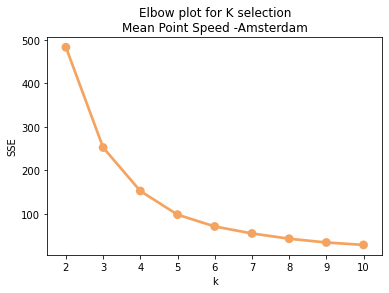

For n_clusters = 2, silhouette score is 0.5831447187554814)
For n_clusters = 3, silhouette score is 0.5385019174780269)
For n_clusters = 4, silhouette score is 0.5279191538009966)
For n_clusters = 5, silhouette score is 0.5422517464272479)
For n_clusters = 6, silhouette score is 0.5336672010536138)
For n_clusters = 7, silhouette score is 0.5289857805689258)
For n_clusters = 8, silhouette score is 0.5279087359292571)
For n_clusters = 9, silhouette score is 0.534600192764414)
4


,Numberplate,Point_speed,Km_travelled,Indicators = OFF,Brakes = OFF,Brakes = ON,Headway Warning (long),Headway Warning (medium),Headway Warning (short),Headway Warning = OFF,...,norm_Lane Departure Warning = OFF,norm_Left Indicator = ON,norm_Left Lane Departure Warning = ON,norm_Left and Right Indicator = ON,norm_Right Indicator = ON,norm_Right Lane Departure Warning = ON,City,Latitude,Longitude,Clusters
0,BBRX80,57.165049,223.600,0.0,0.0,0.0,300.0,31.0,70.0,254.0,...,0.084973,0.000000,0.031306,0.000000,0.000000,0.049195,Amsterdam,NaN,NaN,3
1,BBSN73,63.705882,163.984,0.0,0.0,0.0,47.0,50.0,53.0,34.0,...,0.018294,0.000000,0.006098,0.000000,0.000000,0.012196,Amsterdam,NaN,NaN,1
2,BBXH49,68.750000,64.727,144.0,30.0,28.0,50.0,7.0,8.0,47.0,...,0.077248,0.911521,0.015450,1.050566,0.278091,0.061798,Amsterdam,NaN,NaN,1
3,BFHD67,59.322581,246.842,0.0,0.0,0.0,245.0,45.0,12.0,246.0,...,0.230917,0.000000,0.016205,0.000000,0.000000,0.214712,Amsterdam,NaN,NaN,3
4,BFRT22,42.835165,163.644,0.0,0.0,0.0,176.0,29.0,42.0,157.0,...,0.317763,0.000000,0.012222,0.000000,0.000000,0.305541,Amsterdam,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,NNB302,68.144354,24960.366,0.0,0.0,0.0,3466.0,779.0,281.0,3362.0,...,0.086978,0.000000,0.009054,0.000000,0.000000,0.076922,Amsterdam_complete,51.877866,4.802914,1
756,NNB320,55.833724,12415.630,0.0,0.0,0.0,2569.0,612.0,522.0,2389.0,...,0.081188,0.000000,0.012645,0.000000,0.000000,0.064274,Amsterdam_complete,51.897583,4.616330,3
757,NNB35,52.887682,10536.427,0.0,0.0,0.0,6344.0,842.0,1194.0,6283.0,...,0.109525,0.000000,0.011959,0.000000,0.000000,0.088835,Amsterdam_complete,51.908679,4.787172,3
758,NNB404,60.519960,6317.855,0.0,0.0,0.0,818.0,241.0,119.0,745.0,...,0.062205,0.000000,0.007598,0.000000,0.000000,0.051125,Amsterdam_complete,52.168488,4.741808,3


In [30]:
class Clustering:
    def __init__(self,feature,feature_name,df,increment,decrement):
        self.feature = feature
        self.feature_name = feature_name
        self.df=df
        self.increment =increment
        self.decrement =decrement
        
    def preprocess(self,df):
        """Preprocess data for KMeans clustering"""
    
        data = np.array(self.df[self.feature])
        data=data.reshape(-1, 1)
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        
        return data
    
    
    def elbow_plot(self):
        """Create elbow plot from normalized data"""
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2,11):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        plt.title('Elbow plot for K selection'+"\n"+feature_name+'-'+ city_name)
        plt.xlabel('k')
        plt.ylabel('SSE')
        sns.pointplot(x=list(sse.keys()),y=list(sse.values()),color="sandybrown")
        plt.show()
        
        
    def silhouette_coeff(self):
        """Checking silhouette score"""
        data=self.preprocess(self.df)
        range_n_clusters = range(2,10)
        
        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(data)
            centers = clusterer.cluster_centers_

            score = silhouette_score(data, preds)
            print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
            
            
    def find_k(self):
        """Find the optimum k clusters"""
        
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2, 21):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        kn = KneeLocator(x=list(sse.keys()), 
                    y=list(sse.values()), 
                    curve='convex', 
                    direction='decreasing')
        k = kn.knee + self.increment - self.decrement
        return k
    
    
    def run_kmeans(self):
        """Run KMeans clustering, including the preprocessing of the data
        and the automatic selection of the optimum k. 
        """

        data=self.preprocess(self.df)
        k = self.find_k()
        print(k)
        kmeans = KMeans(n_clusters=k,init='k-means++')
        kmeans.fit(data)
        return self.df.assign(Clusters=kmeans.labels_)
    

clustering_kmeans = Clustering(feature,feature_name,df_grouped_cities,increment=0, decrement=2) # increase or decrease number of assigned clusters using `increment` or `decrement`
clustering_kmeans.elbow_plot() 
clustering_kmeans.silhouette_coeff()
Clusters=clustering_kmeans.run_kmeans()
Clusters
# df_grouped_cities

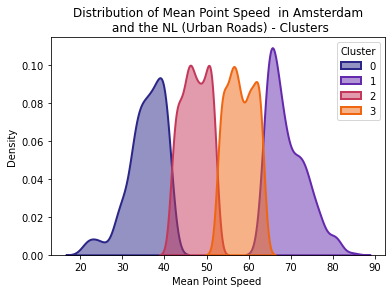

In [31]:
def viz_classes():
    sns.set_palette("CMRmap")
    sns.kdeplot(Clusters[Clusters['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==5][feature],label="5",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster")
    plt.title(r"Distribution of "+feature_name+" in "+ city_name + "\n"+" and the NL (Urban Roads) - Clusters")
    plt.xlabel(feature_name)
    
viz_classes()

<ipython-input-38-16f726fc72fc>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-16f726fc72fc>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-16f726fc72fc>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-16f726fc72fc>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

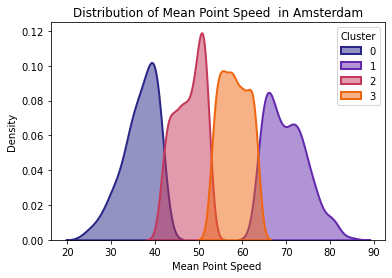

In [38]:

def processing_data_plots(df_clusters):
    df_city=df_clusters.loc[df_clusters['City'] == city_name]
    df_not_city=df_clusters.loc[df_clusters['City'] == city_name+"_complete"]
    
    sns.set_palette("CMRmap")
    sns.kdeplot(df_city[df_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(df_city[df_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster")
    plt.title(r"Distribution of "+ feature_name+" in "+city_name)
    plt.xlabel(feature_name)
    
    
    df_city.drop([' Indicators = OFF',
       'Brakes = OFF', 'Brakes = ON', 'Headway Warning (long)',
       'Headway Warning (medium)', 'Headway Warning (short)',
       'Headway Warning = OFF', 'Lane Departure Warning = OFF',
       'Left Indicator = ON', 'Left Lane Departure Warning = ON',
       'Left and Right Indicator = ON', 'Right Indicator = ON',
       'Right Lane Departure Warning = ON','norm_Indicators = OFF','norm_brakes = OFF','norm_Headway Warning = OFF','norm_Left Indicator = ON', 'norm_Left and Right Indicator = ON', 'norm_Right Indicator = ON'], axis = 1, inplace = True) 
    
    
    df_not_city.drop(['Latitude','Longitude',' Indicators = OFF',
       'Brakes = OFF', 'Brakes = ON', 'Headway Warning (long)',
       'Headway Warning (medium)', 'Headway Warning (short)',
       'Headway Warning = OFF', 'Lane Departure Warning = OFF',
       'Left Indicator = ON', 'Left Lane Departure Warning = ON',
       'Left and Right Indicator = ON', 'Right Indicator = ON',
       'Right Lane Departure Warning = ON','norm_Indicators = OFF','norm_brakes = OFF','norm_Headway Warning = OFF','norm_Left Indicator = ON', 'norm_Left and Right Indicator = ON', 'norm_Right Indicator = ON'], axis = 1, inplace = True) 
    
    df_city.reset_index(drop=True)
    df_city['Numberplate'] = df_city['Numberplate'].astype(str)
    df_city['City'] = df_city['City'].astype(str)
    df_not_city['Numberplate'] = df_not_city['Numberplate'].astype(str)
    df_not_city['City'] = df_not_city['City'].astype(str)
    
    return df_city,df_not_city

    
df_city,df_not_city=processing_data_plots(Clusters)

Text(0.5, 0, 'Cluster')

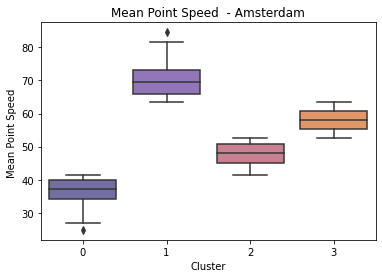

In [39]:
import matplotlib as mpl
ax = sns.boxplot(x=df_city['Clusters'],y=df_city[feature],fliersize=5)
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.7))

plt.title(feature_name+" - "+ city_name)
plt.ylabel(feature_name)
plt.xlabel("Cluster")


In [40]:
df_city_cluster0=df_city[df_city['Clusters']==0]
df_city_cluster0_nums=list(df_city_cluster0['Numberplate'])

df_city_cluster1=df_city[df_city['Clusters']==1]
df_city_cluster1_nums=list(df_city_cluster1['Numberplate'])

df_city_cluster2=df_city[df_city['Clusters']==2]
df_city_cluster2_nums=list(df_city_cluster2['Numberplate'])

df_city_cluster3=df_city[df_city['Clusters']==3]
df_city_cluster3_nums=list(df_city_cluster3['Numberplate'])

df_city_cluster4=df_city[df_city['Clusters']==4]
df_city_cluster4_nums=list(df_city_cluster4['Numberplate'])

df_city_cluster5=df_city[df_city['Clusters']==5]
df_city_cluster5_nums=list(df_city_cluster5['Numberplate'])

In [42]:
df_city_cluster0[feature].median()

37.319148936170215

In [44]:
%%capture
df_not_city_cluster0_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster0_nums)]
df_not_city_cluster0_nums['Cluster_city']=0
df_not_city_cluster1_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster1_nums)]
df_not_city_cluster1_nums['Cluster_city']=1
df_not_city_cluster2_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster2_nums)]
df_not_city_cluster2_nums['Cluster_city']=2
df_not_city_cluster3_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster3_nums)]
df_not_city_cluster3_nums['Cluster_city']=3
df_not_city_cluster4_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster4_nums)]
df_not_city_cluster4_nums['Cluster_city']=4


In [45]:
list_of_dataframes=[df_not_city_cluster0_nums,df_not_city_cluster1_nums,df_not_city_cluster2_nums,df_not_city_cluster3_nums]
df_not_city_new_clus = pd.concat(list_of_dataframes)
df_not_city_new_clus

,Numberplate,Point_speed,Km_travelled,norm_brakes = ON,norm_headway_warning(long),norm_headway_warning(medium),norm_headway_warning(short),norm_Lane Departure Warning = OFF,norm_Left Lane Departure Warning = ON,norm_Right Lane Departure Warning = ON,City,Clusters,Cluster_city
13,BHBZ85,38.023101,15664.924,0.386596,0.648200,0.073285,0.115800,0.080243,0.031152,0.044239,Amsterdam_complete,0,0
17,BHLS93,53.419659,29797.504,0.000000,0.444198,0.043460,0.074167,0.192701,0.020404,0.168773,Amsterdam_complete,3,0
25,BJSP23,42.093178,28416.344,0.334843,0.509003,0.063273,0.091989,0.114160,0.012845,0.097162,Amsterdam_complete,2,0
31,BLFH45,33.572295,20252.724,0.000000,0.080137,0.005283,0.054017,0.028984,0.004394,0.021133,Amsterdam_complete,0,0
51,BLVJ20,58.675552,3229.284,0.000000,0.069985,0.017961,0.010529,0.056979,0.010219,0.042734,Amsterdam_complete,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,BVRB24,61.895621,4309.258,0.000000,0.084933,0.014156,0.002553,0.058711,0.009282,0.048268,Amsterdam_complete,3,3
737,BVRD62,70.052131,7291.648,0.000000,0.075566,0.007817,0.003566,0.084480,0.000823,0.081189,Amsterdam_complete,1,3
746,BVRT98,58.083481,9285.941,0.000000,0.104674,0.021107,0.016369,0.058583,0.006569,0.047707,Amsterdam_complete,3,3
748,BVRV04,61.684785,8724.801,0.000000,0.094100,0.024184,0.008825,0.077366,0.013066,0.063841,Amsterdam_complete,3,3


Text(0.5, 1.0, 'Mean Point Speed  of corresponding \nnumber plates based on assigned cluster')

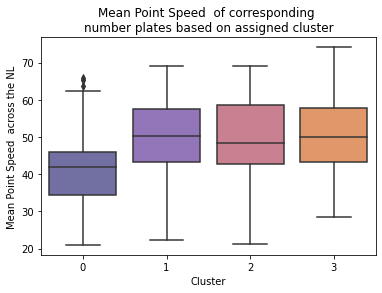

In [46]:
import matplotlib as mpl
ax = sns.boxplot(x=df_not_city_new_clus['Cluster_city'],y=df_not_city_new_clus[feature],fliersize=5)
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.7))
    
plt.ylabel(feature_name+" across the NL")
plt.xlabel("Cluster")
plt.title(feature_name+ " of corresponding "+"\n"+r"number plates based on assigned cluster")
# plt.ylim(-0.1,1.4)

In [47]:
df_outer = pd.merge(df_city, df_not_city_new_clus, on='Numberplate', how='inner') #here Numberplate is common column
df_outer

,Numberplate,Point_speed_x,Km_travelled_x,norm_brakes = ON_x,norm_headway_warning(long)_x,norm_headway_warning(medium)_x,norm_headway_warning(short)_x,norm_Lane Departure Warning = OFF_x,norm_Left Lane Departure Warning = ON_x,norm_Right Lane Departure Warning = ON_x,...,norm_brakes = ON_y,norm_headway_warning(long)_y,norm_headway_warning(medium)_y,norm_headway_warning(short)_y,norm_Lane Departure Warning = OFF_y,norm_Left Lane Departure Warning = ON_y,norm_Right Lane Departure Warning = ON_y,City_y,Clusters_y,Cluster_city
0,BBRX80,57.165049,223.600,0.000000,1.341682,0.138640,0.313059,0.084973,0.031306,0.049195,...,0.000000,0.806469,0.087170,0.158690,0.107819,0.025392,0.079841,Amsterdam_complete,2,3
1,BBSN73,63.705882,163.984,0.000000,0.286613,0.304908,0.323202,0.018294,0.006098,0.012196,...,0.000000,0.310682,0.188808,0.281174,0.012462,0.003527,0.003527,Amsterdam_complete,2,1
2,BBXH49,68.750000,64.727,0.432586,0.772475,0.108147,0.123596,0.077248,0.015450,0.061798,...,0.436848,0.722173,0.109365,0.156465,0.057598,0.025217,0.028383,Amsterdam_complete,0,1
3,BFHD67,59.322581,246.842,0.000000,0.992538,0.182303,0.048614,0.230917,0.016205,0.214712,...,0.000000,0.670310,0.097183,0.137367,0.160071,0.039300,0.117753,Amsterdam_complete,2,3
4,BFRT22,42.835165,163.644,0.000000,1.075505,0.177214,0.256655,0.317763,0.012222,0.305541,...,0.000000,0.765427,0.139902,0.207561,0.297315,0.021453,0.272653,Amsterdam_complete,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,NNB302,72.776860,264.858,0.000000,0.135922,0.045307,0.015102,0.052859,0.003776,0.052859,...,0.000000,0.138860,0.031209,0.011258,0.086978,0.009054,0.076922,Amsterdam_complete,1,1
748,NNB320,43.442623,111.351,0.000000,0.359224,0.098787,0.152670,0.053884,0.008981,0.035922,...,0.000000,0.206917,0.049293,0.042044,0.081188,0.012645,0.064274,Amsterdam_complete,3,2
749,NNB35,74.659091,222.154,0.000000,1.661010,0.256579,0.045014,0.193559,0.022507,0.162050,...,0.000000,0.602102,0.079913,0.113321,0.109525,0.011959,0.088835,Amsterdam_complete,3,1
750,NNB404,49.850000,162.062,0.000000,0.098728,0.024682,0.018511,0.030852,0.000000,0.024682,...,0.000000,0.129474,0.038146,0.018836,0.062205,0.007598,0.051125,Amsterdam_complete,3,2


In [48]:
df_outer.rename(columns={'Point_speed_x': 'Mean Point Speed in '+location,
                         'Point_speed_y': 'Mean Point Speed '+location1,
                         'norm_brakes = ON_x': 'Norm Braking Events in '+location,
                         'norm_brakes = ON_y': 'Norm Braking Events '+location1,
                         'norm_headway_warning(long)_x': 'Norm L(I)-HW in '+location,
                         'norm_headway_warning(long)_y': 'Norm L(I)-HW '+location1,
                         'norm_headway_warning(medium)_x': 'Norm L(II)-HW in '+location,
                         'norm_headway_warning(medium)_y': 'Norm L(II)-HW '+location1,
                         'norm_headway_warning(short)_x': 'Norm L(III)-HW in '+location,
                         'norm_headway_warning(short)_y': 'Norm L(III)-HW '+location1,
                         'norm_Right Lane Departure Warning = ON_x': 'Norm R-LDW in '+location,
                         'norm_Right Lane Departure Warning = ON_y': 'Norm R-LDW '+location1,
                         'norm_Left Lane Departure Warning = ON_x': 'Norm L-LDW in '+location,
                         'norm_Left Lane Departure Warning = ON_y': 'Norm L-LDW '+location1
                         },
          inplace=True, errors='raise')

In [49]:
df_outer['cluster_comp'] = np.where(df_outer['Clusters_x']==df_outer['Clusters_y'], 'True', 'False')

In [50]:
a=df_outer[df_outer['cluster_comp']=='True']
# a['clusters_utrecht'].value_counts()
len(df_outer[df_outer['cluster_comp']=='True'])/len(df_outer)*100

28.590425531914892

In [51]:
a['Clusters_x'].value_counts()/len(a)*100

3    37.674419
2    35.348837
0    14.418605
1    12.558140
Name: Clusters_x, dtype: float64

In [52]:
df_outer['Clusters_x'].value_counts()

3    260
1    236
2    192
0     64
Name: Clusters_x, dtype: int64

In [53]:
list_of_dataframes=[df_city,df_not_city_new_clus]
df_boxplot_clus = pd.concat(list_of_dataframes)
df_boxplot_clus

,Numberplate,Point_speed,Km_travelled,norm_brakes = ON,norm_headway_warning(long),norm_headway_warning(medium),norm_headway_warning(short),norm_Lane Departure Warning = OFF,norm_Left Lane Departure Warning = ON,norm_Right Lane Departure Warning = ON,City,Latitude,Longitude,Clusters,Cluster_city
0,BBRX80,57.165049,223.600,0.000000,1.341682,0.138640,0.313059,0.084973,0.031306,0.049195,Amsterdam,NaN,NaN,3,NaN
1,BBSN73,63.705882,163.984,0.000000,0.286613,0.304908,0.323202,0.018294,0.006098,0.012196,Amsterdam,NaN,NaN,1,NaN
2,BBXH49,68.750000,64.727,0.432586,0.772475,0.108147,0.123596,0.077248,0.015450,0.061798,Amsterdam,NaN,NaN,1,NaN
3,BFHD67,59.322581,246.842,0.000000,0.992538,0.182303,0.048614,0.230917,0.016205,0.214712,Amsterdam,NaN,NaN,3,NaN
4,BFRT22,42.835165,163.644,0.000000,1.075505,0.177214,0.256655,0.317763,0.012222,0.305541,Amsterdam,NaN,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,BVRB24,61.895621,4309.258,0.000000,0.084933,0.014156,0.002553,0.058711,0.009282,0.048268,Amsterdam_complete,NaN,NaN,3,3.0
737,BVRD62,70.052131,7291.648,0.000000,0.075566,0.007817,0.003566,0.084480,0.000823,0.081189,Amsterdam_complete,NaN,NaN,1,3.0
746,BVRT98,58.083481,9285.941,0.000000,0.104674,0.021107,0.016369,0.058583,0.006569,0.047707,Amsterdam_complete,NaN,NaN,3,3.0
748,BVRV04,61.684785,8724.801,0.000000,0.094100,0.024184,0.008825,0.077366,0.013066,0.063841,Amsterdam_complete,NaN,NaN,3,3.0


Text(0.5, 0, 'Mean Point Speed ')

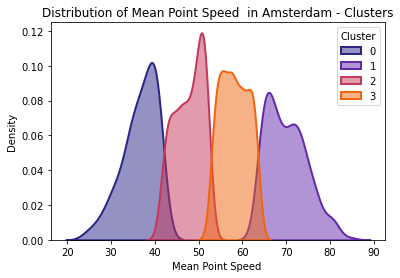

In [55]:
sns.set_palette("CMRmap")
sns.kdeplot(df_city[df_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
# sns.kdeplot(df_city[df_city['Clusters']==3]['Point_speed'],label="3",fill=True,alpha=0.5,linewidth=2)
# sns.kdeplot(df_city[df_city['Clusters']==4]['Point_speed'],label="4",fill=True,alpha=0.5,linewidth=2)
# sns.kdeplot(df_city[df_city['Clusters']==5]['Point_speed'],label="5",fill=True,alpha=0.5,linewidth=2)
plt.legend(title="Cluster")
plt.title(r"Distribution of "+feature_name+" in "+city_name+" - Clusters")
# plt.xlabel("Mean Point Speed (km/h)")

# plt.title(feature_name+" in "+ city_name +"- Clusters")
plt.xlabel(feature_name)

In [63]:
feature_x= feature_name+'in '
feature_y=feature_name

Text(0.5, 1.0, 'Mean Point Speed  of Numberplates \nand their corresponding clusters')

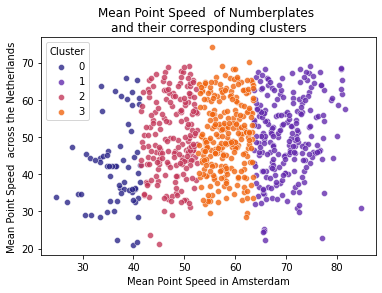

In [65]:
sns.set_palette("CMRmap")
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==0],x=feature_x+location,y=feature_y+location1,alpha=0.8,label=0)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==1],x=feature_x+location,y=feature_y+location1,alpha=0.8,label=1)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==2],x=feature_x+location,y=feature_y+location1,alpha=0.8,label=2)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==3],x=feature_x+location,y=feature_y+location1,alpha=0.8,label=3)
plt.legend(title="Cluster")
plt.xlabel(feature_x+city_name)
plt.ylabel(feature_y+" across the Netherlands")
plt.title(feature_y+" of Numberplates "+"\n"+"and their corresponding clusters")

In [66]:
df_grp_td_aos_ams=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Amsterdam\df_grp_aos_trip_detail_amsterdam.csv")
df_grp_td_aos_zwolle=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_zwolle.csv")
# df_grp_td_aos_ein=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Eindhoven\df_grp_aos_trip_detail_eindhoven.csv")
df_grp_td_aos_rotte=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Rotterdam\df_grp_aos_trip_detail_rotterdam.csv")
# df_grp_td_aos_utrecht=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Utrecht\df_grp_aos_trip_detail_utrecht.csv")
# df_grp_td_aos_zwolle=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering\Summary\Zwolle\df_grp_aos_trip_detail_zwolle.csv")

In [67]:
import pandas as pd
list_of_dataframes=[df_grp_td_aos_ams,df_grp_td_aos_rotte,df_grp_td_aos_zwolle]
df = pd.concat(list_of_dataframes)

In [68]:
df.drop(['Overspeeding_event_sum_intra_city','norm_overspeeding', ' Indicators = OFF', 'Brakes = OFF', 'Brakes = ON',
       'Headway Warning (long)', 'Headway Warning (medium)',
       'Headway Warning (short)', 'Headway Warning = OFF',
       'Lane Departure Warning = OFF', 'Left Indicator = ON',
       'Left Lane Departure Warning = ON', 'Left and Right Indicator = ON',
       'Right Indicator = ON', 'Right Lane Departure Warning = ON',
       'norm_Indicators = OFF', 'norm_brakes = OFF','norm_Headway Warning = OFF',
       'norm_Lane Departure Warning = OFF', 'norm_Left Indicator = ON','norm_Right Indicator = ON'], axis = 1, inplace = True) 


In [69]:
df.rename(columns={'Point_speed_mean_intra_city': 'Mean Point Speed (km/h)',
                   'KmTravelled_sum_intra_city':'Distance Covered (km)',
                   'norm_brakes = ON':'Normalized Braking Events',
                   'norm_headway_warning(long)': 'Normalized Level I-HW',
                   'norm_headway_warning(medium)': 'Normalized Level II-HW',
                   'norm_headway_warning(short)': 'Normalized Level III-HW',
                   'norm_Right Lane Departure Warning = ON': 'Normalized R-LDW',
                   'norm_Left Lane Departure Warning = ON': 'Normalized L-LDW'},
          inplace=True, errors='raise')

In [70]:
df = df.drop(df[df['Normalized Braking Events']>4].index)
df = df.drop(df[df['Normalized Level I-HW']>3].index)
# df = df.drop(df[df.score < 50].index)
# df = df.drop(df[df.score < 50].index)


In [71]:
df['Numberplate Count']=1
df_sum=df.groupby(['City']).sum("Numberplate")
df_sum.reset_index(inplace=True)

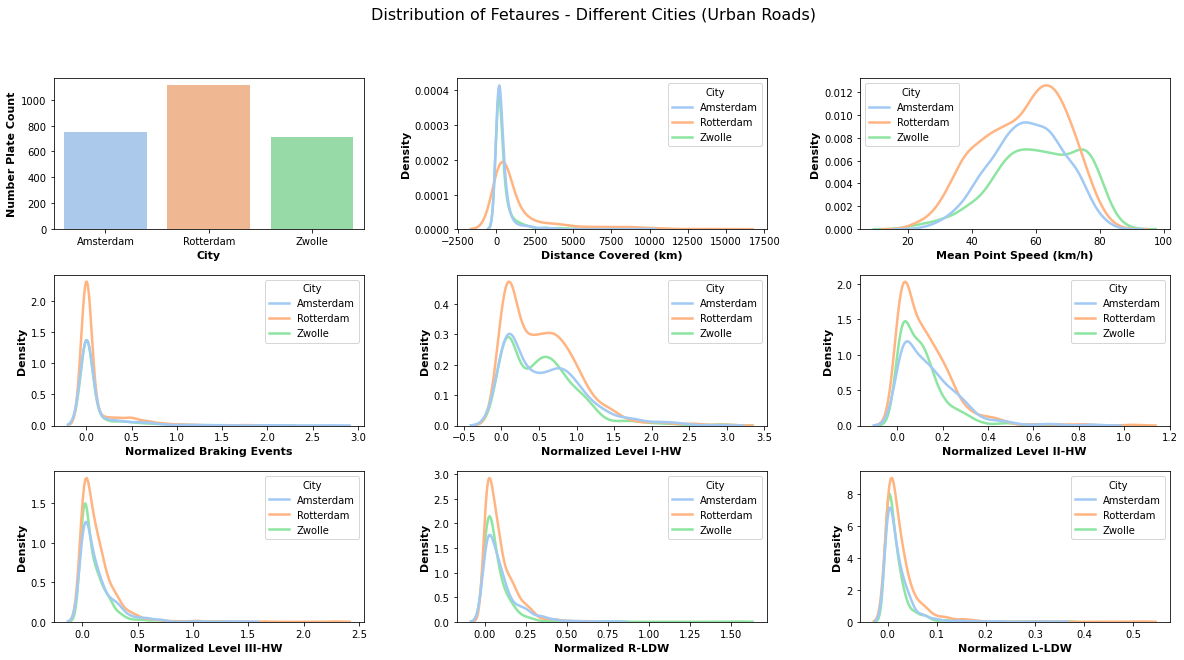

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
# sns.set_context("notebook")
fig.suptitle('Distribution of Fetaures - Different Cities (Urban Roads)',fontsize=16)
# sns.set_context("notebook", font_scale=1.25)
sns.barplot(ax=axes[0,0],data=df_sum,y="Numberplate Count",x="City",palette="pastel")
axes[0,0].set_xlabel('City',fontsize=11, fontdict=dict(weight='bold'))
axes[0,0].set_ylabel('Number Plate Count',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[0, 1], data=df, x='Distance Covered (km)',linewidth=2.5,hue="City",palette="pastel")
axes[0,1].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[0,1].set_xlabel('Distance Covered (km)',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[0, 2], data=df, x='Mean Point Speed (km/h)',linewidth=2.5,hue="City",palette="pastel")
axes[0,2].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[0,2].set_xlabel('Mean Point Speed (km/h)',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[1, 0], data=df, x='Normalized Braking Events',linewidth=2.5,hue="City",palette="pastel")
axes[1,0].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[1,0].set_xlabel('Normalized Braking Events',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[1, 1], data=df, x='Normalized Level I-HW',linewidth=2.5,hue="City",palette="pastel")
axes[1,1].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[1,1].set_xlabel('Normalized Level I-HW',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[1, 2], data=df, x='Normalized Level II-HW',linewidth=2.5,hue="City",palette="pastel")
axes[1,2].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[1,2].set_xlabel('Normalized Level II-HW',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[2, 0], data=df, x='Normalized Level III-HW',linewidth=2.5,hue="City",palette="pastel")
axes[2,0].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[2,0].set_xlabel('Normalized Level III-HW',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[2, 1], data=df, x='Normalized R-LDW',linewidth=2.5,hue="City",palette="pastel")
axes[2,1].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[2,1].set_xlabel('Normalized R-LDW',fontsize=11,fontdict=dict(weight='bold'))
sns.kdeplot(ax=axes[2,2], data=df, x='Normalized L-LDW',linewidth=2.5,hue="City",palette="pastel")
axes[2,2].set_ylabel('Density',fontsize=11, fontdict=dict(weight='bold'))
axes[2,2].set_xlabel('Normalized L-LDW',fontsize=11,fontdict=dict(weight='bold'))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3) #make the figure look better